# Статистический анализ данных сервиса аренды самокатов

**Цель исследования**:

1. Изучить данные пользователей сервиса аренды самокатов GoFast, о совершенных пользователями поездках, об используемых пользователями видах подписки.
2. Проверить ряд статистических гипотез по данным поездок пользователей, использующих и неиспользующих подписку.

  **Ход исследования:**
    Данные я получу из файлов `'/datasets/users_go.csv', '/datasets/rides_go.csv', '/datasets/subscriptions_go.csv'`. О качестве данных ничего не известно. Поэтому перед тем, как приступать к целям исследования, понадобится обзор данных.
    
    Я проверю данные на ошибки и оценю их влияние на исследование. Затем, на этапе предобработки я поищу возможность исправить все ошибки данных, которые не приведут к искажению конечного результата. Далее, создам необходимые столбцы и приступлю к проведению статистического анализа данных.
    
    Таким образом, мое исследование пройдет в шесть этапов:
    - Обзор данных.
    - Предобработка данных.
    - Исследовательский анализ данных.
    - Объединение данных.
    - Добавление новых столбцов.
    - Проверка гипотез.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from scipy import stats as st

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format='{:,.2f}'.format
rcParams['figure.figsize'] = 10, 7

## Загрузка данных

In [ ]:
try:
    users, rides, subscriptions = (pd.read_csv('/datasets/users_go.csv'),
                                   pd.read_csv('/datasets/rides_go.csv'),
                                   pd.read_csv('/datasets/subscriptions_go.csv')
    )
except:
    users, rides, subscriptions = (pd.read_csv('https://code.s3.yandex.net//datasets/users_go.csv'),
                                   pd.read_csv('https://code.s3.yandex.net//datasets/rides_go.csv'),
                                   pd.read_csv('https://code.s3.yandex.net//datasets/subscriptions_go.csv')
    )

In [ ]:
def get_info_df(df):
    display(df.head())
    display(df.info())

In [ ]:
get_info_df(users)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

In [ ]:
get_info_df(rides)

,user_id,distance,duration,date
0,1,"4,409.92",25.60,2021-01-01
1,1,"2,617.59",15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,"2,694.78",18.51,2021-08-11
4,1,"4,028.69",26.27,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

In [ ]:
get_info_df(subscriptions)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


None

**Вывод по разделу "Загрузка данных":**

1. В представленных данных есть информация о 1565 пользователях сервиса, о 18068 совершенных ими поездках, и типах подписки при использовании мобильного приложения сервиса.
2. В столбце `date` установлен формат данных `object`, приведем столбец к типу даты pandas в разделе "Предобработка данных"

## Предобработка данных

In [ ]:
# сделаем контроль размера датасетов до и после обработки.
users_copy, rides_copy = users.copy(), rides.copy()
len(users_copy), len(rides_copy)

(1565, 18068)

### Приведем столбцы к нужному формату

In [ ]:
# приведем даты к формату datetime
rides['date'] = pd.to_datetime(rides['date'])
display(rides['date'].head())

,date
0,2021-01-01
1,2021-01-18
2,2021-04-20
3,2021-08-11
4,2021-08-28


### Создадим новые столбцы

In [ ]:
# cоздадим новый столбец с номером месяца на основе столбца `date`
rides['month']=rides['date'].dt.to_period('M')
rides['month'].head()

,month
0,2021-01
1,2021-01
2,2021-04
3,2021-08
4,2021-08


### Изучим пропуски в данных

In [ ]:
users.isna().sum(), rides.isna().sum()

(user_id              0
 name                 0
 age                  0
 city                 0
 subscription_type    0
 dtype: int64,
 user_id     0
 distance    0
 duration    0
 date        0
 month       0
 dtype: int64)

### Изучим дубликаты

In [ ]:
users.duplicated().sum(), rides.duplicated().sum()

(np.int64(31), np.int64(0))

In [ ]:
list=users[users.duplicated()==True]['user_id'].to_list()
users.query('user_id in @list').sort_values(by='user_id')

,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1539,43,Стефания,22,Омск,ultra
42,43,Стефания,22,Омск,ultra
46,47,Юрий,28,Тюмень,ultra
1563,47,Юрий,28,Тюмень,ultra
1555,72,Никита,25,Москва,ultra
71,72,Никита,25,Москва,ultra
107,108,Влада,29,Тюмень,ultra
1549,108,Влада,29,Тюмень,ultra


In [ ]:
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

np.int64(0)

In [ ]:
a, b = len(users_copy), len(users)
print(a, b, a-b, round((a-b)/a*100, 1))

1565 1534 31 2.0


**Вывод по разделу "Предобработка данных":**
1. Даты в столбце `date` датафрейма `rides` приведены к формату datetime
2. Создан новый столбец `month` в датафрейме `rides`
3. Установлено отсутствие пропусков в данных.
4. Удален 31 дубликат в датафрейме с пользователями приложения (удалено 2% данных `users`).

## Исследовательский анализ данных

### Исследуем частоту встречаемости городов

In [ ]:
users.pivot_table(
    index='city',
    values='user_id',
    aggfunc='count').sort_values(by='user_id', ascending=False).style.background_gradient()

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [ ]:
data_city=users.groupby('city', as_index = False)['user_id'].count().sort_values('user_id', ascending=False)
data_city

,city,user_id
4,Пятигорск,219
0,Екатеринбург,204
5,Ростов-на-Дону,198
1,Краснодар,193
6,Сочи,189
3,Омск,183
7,Тюмень,180
2,Москва,168


/tmp/ipython-input-18-2162426972.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x='user_id', y='city', data=data_city, palette=sns.color_palette('turbo', 32))
/tmp/ipython-input-18-2162426972.py:1: UserWarning: The palette list has more values (32) than needed (8), which may not be intended.
  ax=sns.barplot(x='user_id', y='city', data=data_city, palette=sns.color_palette('turbo', 32))


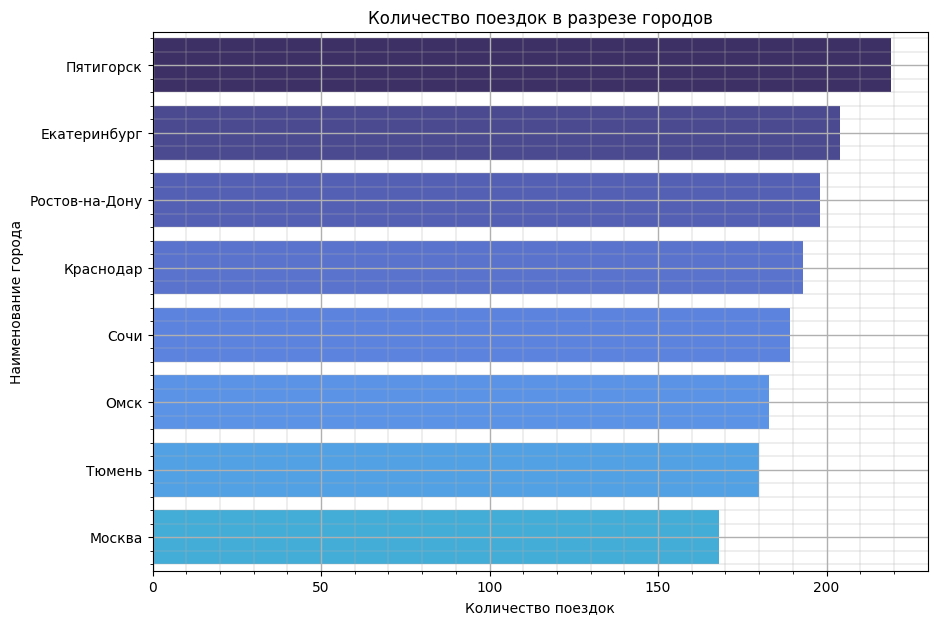

In [ ]:
ax=sns.barplot(x='user_id', y='city', data=data_city, palette=sns.color_palette('turbo', 32))
ax.set_title('''Количество поездок в разрезе городов''', size=12)
ax.set_xlabel('Количество поездок', size=10)
ax.set_ylabel('Наименование города', size=10)
ax.grid(False)
ax.grid(True, which = "major", linewidth = 1)
ax.grid(which = "minor", linewidth = 0.3)
ax.minorticks_on()
plt.show()

**Вывод по разделу "Исследование частоты встречаемости городов":**

Данные представлены о 1534 пользователях сервиса из 8 городов, наиболее активно регистрировались в приложении пользователи в Пятигорске, Екатеринбурге, Ростове-на-Дону и Краснодаре.

### Исследуем соотношение пользователей с подпиской и без подписки

In [ ]:
df=users.groupby('subscription_type', as_index = False)['user_id'].count()
df

,subscription_type,user_id
0,free,835
1,ultra,699


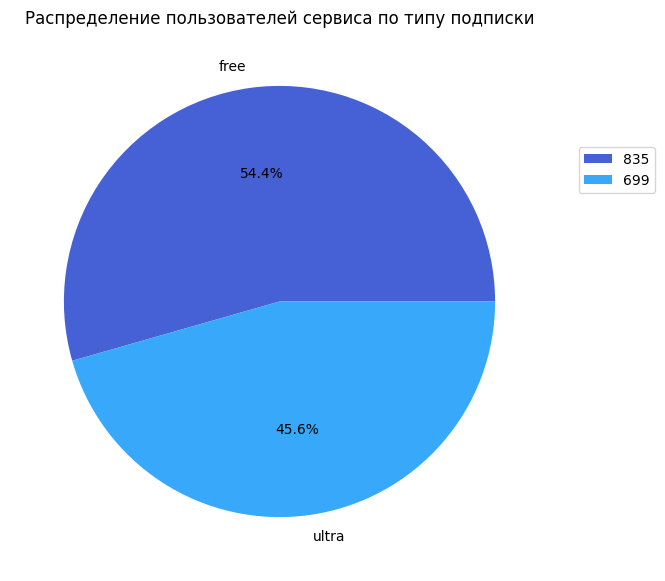

In [ ]:
plt.pie(df['user_id'], labels=df['subscription_type'], \
           colors=sns.color_palette('turbo', 8), \
           autopct='%.1f%%')
plt.title('Распределение пользователей сервиса по типу подписки', size=12)
plt.legend(
    bbox_to_anchor = (0.96, 0.35, 0.25, 0.45),
    labels = df['user_id'])
plt.show()

**Вывод по разделу "Исследование соотношения пользователей с подпиской и без подписки":**

Наиболее часто сервисом пользуются без подписки - 54,4% пользователей.

### Исследуем возраст пользователей

In [ ]:
users['age'].describe()

,age
count,"1,534.00"
mean,24.90
std,4.57
min,12.00
25%,22.00
50%,25.00
75%,28.00
max,43.00


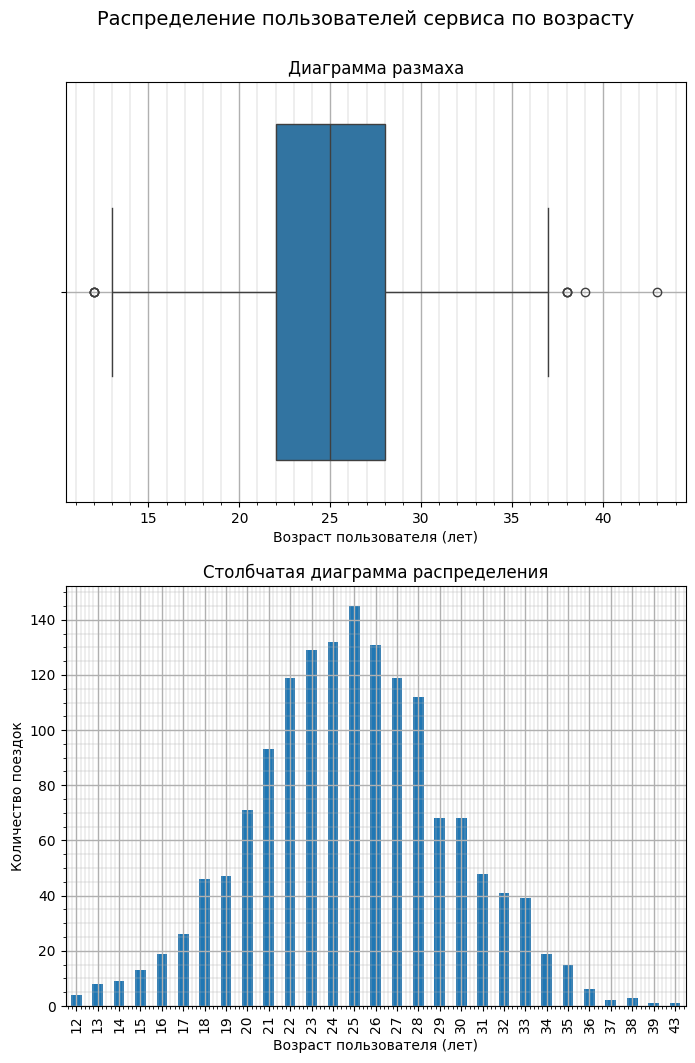

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12))
fig.suptitle('Распределение пользователей сервиса по возрасту', y=0.94, size=14)

sns.boxplot(data=users, x='age', ax=axes[0])
axes[0].set_title('''Диаграмма размаха''', size=12)
axes[0].set_xlabel('Возраст пользователя (лет)', size=10)
axes[0].grid(True, which = "major", linewidth = 1)
axes[0].grid(which = "minor", linewidth = 0.3)
axes[0].minorticks_on()

users['age'].value_counts().sort_index().plot.bar(ax=axes[1])
axes[1].set_title('''Столбчатая диаграмма распределения''', size=12)
axes[1].set_xlabel('Возраст пользователя (лет)', size=10)
axes[1].set_ylabel('Количество поездок', size=10)
axes[1].grid(True, which = "major", linewidth = 1)
axes[1].grid(which = "minor", linewidth = 0.3)
axes[1].minorticks_on()

plt.show()

**Вывод по разделу "Исследование возраста пользователей":**

Сервисом проката пользуются в возрасте от 12 до 43 лет, наиболее активные пользователи в возрасте от 22 до 28 лет.

### Проанализируем расстояние, которое пользователь преодолел за одну поездку

In [ ]:
rides['distance'].describe()

,distance
count,"18,068.00"
mean,"3,070.66"
std,"1,116.83"
min,0.86
25%,"2,543.23"
50%,"3,133.61"
75%,"3,776.22"
max,"7,211.01"


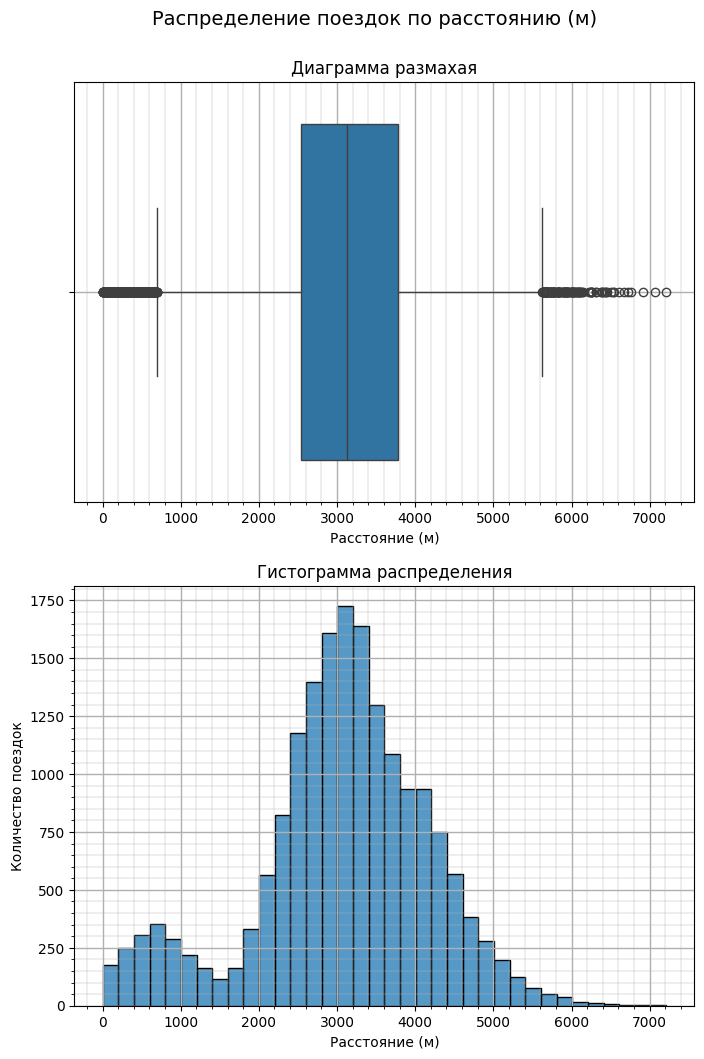

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12))
fig.suptitle('Распределение поездок по расстоянию (м)', y=0.94, size=14)

sns.boxplot(data=rides, x='distance', ax=axes[0])
axes[0].set_title('''Диаграмма размахая''', size=12)
axes[0].set_xlabel('Расстояние (м)', size=10)
axes[0].grid(True, which = "major", linewidth = 1)
axes[0].grid(which = "minor", linewidth = 0.3)
axes[0].minorticks_on()

sns.histplot(x='distance', data=rides, bins=36, ax=axes[1])
axes[1].set_title('''Гистограмма распределения''', size=12)
axes[1].set_xlabel('Расстояние (м)', size=10)
axes[1].set_ylabel('Количество поездок', size=10)
axes[1].grid(True, which = "major", linewidth = 1)
axes[1].grid(which = "minor", linewidth = 0.3)
axes[1].minorticks_on()
plt.show()

**Вывод по разделу "Исследование расстояния, которое пользователь преодолел за одну поездку":**

Расстояние поездок составляет от 0,86 м до 7,21 км. Наиболее частые поездки на расстояние от 2,5 до 3,8 км.

### Исследуем продолжительность поездок

In [ ]:
rides['duration'].describe()

,duration
count,"18,068.00"
mean,17.81
std,6.09
min,0.50
25%,13.60
50%,17.68
75%,21.72
max,40.82


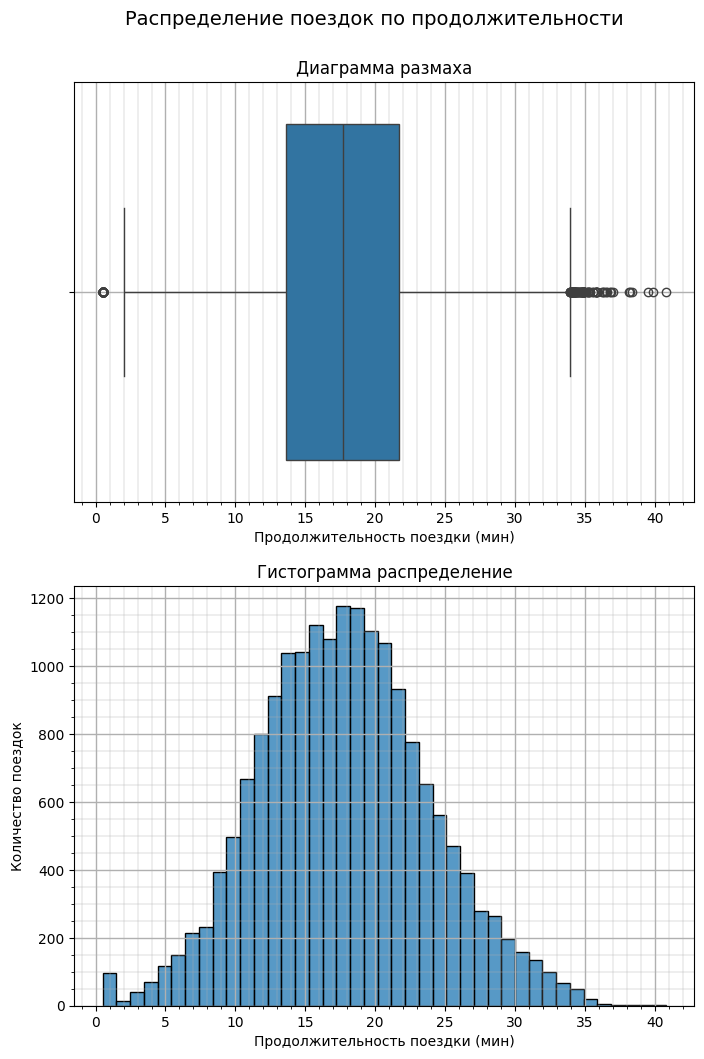

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12))
fig.suptitle('Распределение поездок по продолжительности', y=0.94, size=14)

sns.boxplot(data=rides, x='duration', ax=axes[0])
axes[0].set_title('''Диаграмма размаха''', size=12)
axes[0].set_xlabel('Продолжительность поездки (мин)', size=10)
axes[0].grid(True, which = "major", linewidth = 1)
axes[0].grid(which = "minor", linewidth = 0.3)
axes[0].minorticks_on()

sns.histplot(x='duration', data=rides, bins=41, ax=axes[1])
axes[1].set_title('''Гистограмма распределение''', size=12)
axes[1].set_xlabel('Продолжительность поездки (мин)', size=10)
axes[1].set_ylabel('Количество поездок', size=10)
axes[1].grid(True, which = "major", linewidth = 1)
axes[1].grid(which = "minor", linewidth = 0.3)
axes[1].minorticks_on()
plt.show()

**Вывод по разделу "Исследование продолжительности поездок":**

Продолжительность поездок составляет от 0,5 до 40,8 мин. Чаще всего совершают поездки продолжительностью от 13,6 до 21,7 мин.

**Вывод по разделу "Исследовательский анализ данных":**
1. Данные представлены о 1534 пользователях сервиса из 8 городов, наиболее активно регистрировались в приложении пользователи в Пятигорске, Екатеринбурге, Ростове-на-Дону и Краснодаре.
2. Наиболее часто сервисом пользуются без подписки - 54,4% пользователей.
3. Сервисом проката пользуются в возрасте от 12 до 43 лет, наиболее активные пользователи в возрасте от 22 до 28 лет.
4. Расстояние поездок составляет от 0,86 м до 7,21 км. Наиболее частые поездки на расстояние от 2,5 до 3,8 км.
5. Продолжительность поездок составляет от 0,5 до 40,8 мин. Чаще всего совершают поездки продолжительностью от 13,6 до 21,7 мин.


## Объединение данных

### Объеденим данные о поездках с данными о пользователях и видах подписки

In [ ]:
# измерим датафреймы до объединения
display(rides.shape, users.shape, subscriptions.shape)

(18068, 5)

(1534, 5)

(2, 4)

In [ ]:
# объединим датафреймы и сделаем контроль размеров конечного датафрейма
df=pd.merge(rides, users, on='user_id', how='left')
df=pd.merge(df, subscriptions, on='subscription_type', how='left')
display(df.head(), df.shape)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,"4,409.92",25.60,2021-01-01,2021-01,Кира,22,Тюмень,ultra,6,0,199
1,1,"2,617.59",15.82,2021-01-18,2021-01,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,6.23,2021-04-20,2021-04,Кира,22,Тюмень,ultra,6,0,199
3,1,"2,694.78",18.51,2021-08-11,2021-08,Кира,22,Тюмень,ultra,6,0,199
4,1,"4,028.69",26.27,2021-08-28,2021-08,Кира,22,Тюмень,ultra,6,0,199


(18068, 12)

### Исследуем распределение поездок по расстоянию и продолжительности для пользователей с подпиской (ultra) и без подписки (free)

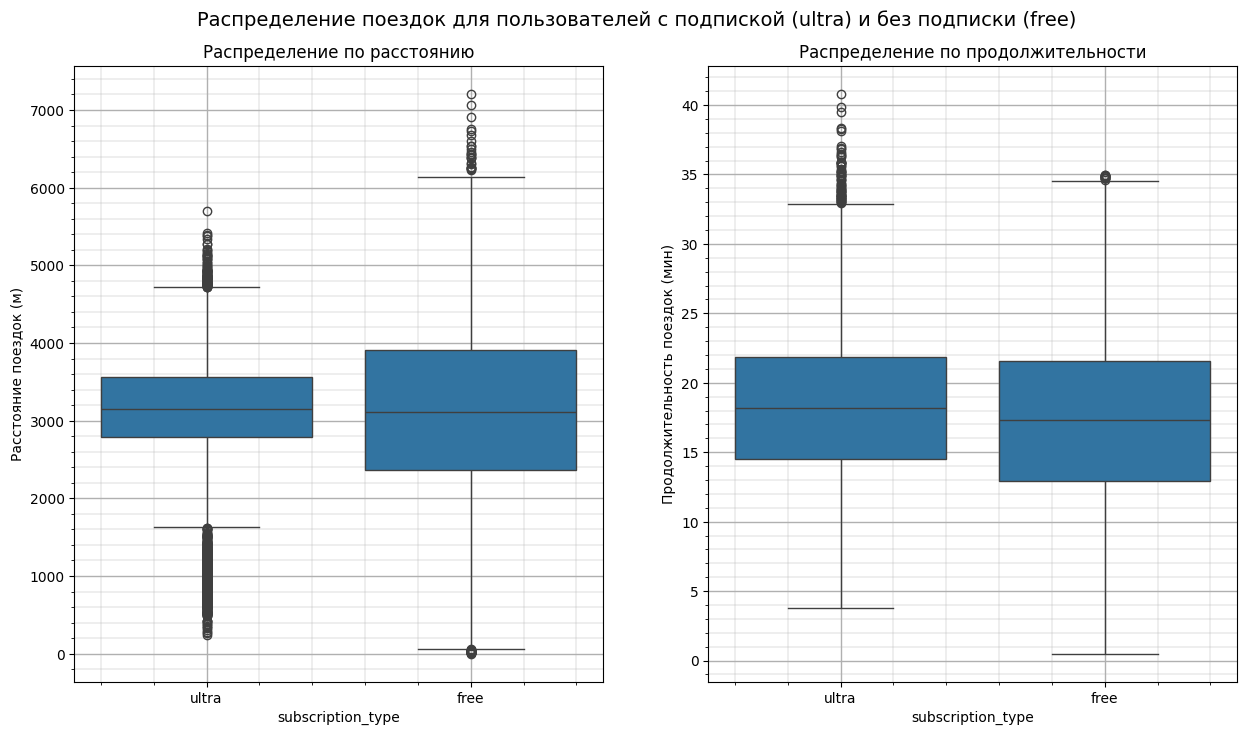

In [ ]:
# визуализируем распределение поездок по расстоянию и продолжительности для пользователей с подпиской (ultra) и без (free)
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle('Распределение поездок для пользователей с подпиской (ultra) и без подписки (free)', y=0.95, size=14)

sns.boxplot(data=df, y='distance', x='subscription_type', ax=axes[0])
axes[0].set_title('''Распределение по расстоянию''', size=12)
axes[0].set_ylabel('Расстояние поездок (м)', size=10)
axes[0].grid(True, which = "major", linewidth = 1)
axes[0].grid(which = "minor", linewidth = 0.3)
axes[0].minorticks_on()

sns.boxplot(y='duration', data=df, x='subscription_type', ax=axes[1])
axes[1].set_title('''Распределение по продолжительности''', size=12)
axes[1].set_ylabel('Продолжительность поездок (мин)', size=10)
axes[1].grid(True, which = "major", linewidth = 1)
axes[1].grid(which = "minor", linewidth = 0.3)
axes[1].minorticks_on()

plt.show()

- Медианное значение **расстояния поездок** у пользователей с подпиской и без подписки практически совпадают - около 3,1 км.
- Размах проезжемых расстояний (без учета выбросов) с подпиской от 1,6 км до 4,7 км, клиенты сервиса с подпиской чаще проезжат расстояния от 2,8 км до 3,6 км.
- Без подписки размах расстояний (без учета выбросов) значительно больше - от нескольких метров до 6,1 км, чаще клиенты с подпиской преодолевают расстояния от 2,2 км до 3,9 км.
- Медианное значение **продолжительности поездок** у пользователей с подпиской больше на 1 мин.
- Размах времени в пути (без учета выбросов) с подпиской от 4 мин. до 33 мин., чаще с подпиской ездят от 14,5 мин до 22 мин.
- Без подписки размах продолжительности  от нескольких секунд до 34,5 мин, без подписки чаще проезжают от 13 мин до 21,5 мин.

**Вывод по разделу "Объединение данных":**
1. Объеденены данные о поездках с данными о пользователях сервиса и видах подписки.
2. Проведен контроль размера датасетов до объединения и после, все данные вошли в итоговый датафрейм.
3. Медианное значение расстояния поездок у пользователей с подпиской и без практически совпадают - около 3,1 км. Без подписки разброс расстояний больше - от нескольких метров до 6,1 км.
4. Медианные значения продолжительности поездок у пользователей с подпиской и без близки по значению - 18 и 17 мин. Разброс расстояний поездок у пользователей с подпиской и без также близки по значению от нескольких минут до 33-34 мин.


## Подсчёт выручки

In [ ]:
# Округлим продолжительность каждой поездки в исходном датафрейме до следующего целого числа
df['duration_rnd']=np.ceil(df['duration'])
df[['duration', 'duration_rnd']].head()

,duration,duration_rnd
0,25.60,26.00
1,15.82,16.00
2,6.23,7.00
3,18.51,19.00
4,26.27,27.00


In [ ]:
# Создадим датафрейм с агрегированными данными о поездках: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
df_revenue=df.groupby(['user_id', 'month', 'subscription_type', 'minute_price',	'start_ride_price',	'subscription_fee']).agg(
    {'distance':'sum', 'duration_rnd':'sum', 'name':'count'}
    ).reset_index()
df_revenue=df_revenue.rename(columns={'name':'rides_cnt'})
df_revenue=df_revenue[['user_id', 'month', 'distance', 'duration_rnd', 'rides_cnt', 'subscription_type', 'minute_price', \
                       'start_ride_price', 'subscription_fee']]
df_revenue.head()

,user_id,month,distance,duration_rnd,rides_cnt,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,2021-01,"7,027.51",42.00,2,ultra,6,0,199
1,1,2021-04,754.16,7.00,1,ultra,6,0,199
2,1,2021-08,"6,723.47",46.00,2,ultra,6,0,199
3,1,2021-10,"5,809.91",32.00,2,ultra,6,0,199
4,1,2021-11,"7,003.50",56.00,3,ultra,6,0,199


In [ ]:
# Добавим столбец с помесячной выручкой, которую принёс каждый пользователь.
df_revenue['revenue_monthly']=(
    df_revenue['start_ride_price']*df_revenue['rides_cnt'] +
    df_revenue['minute_price']*df_revenue['duration_rnd'] + df_revenue['subscription_fee']
)
df_revenue.head()

,user_id,month,distance,duration_rnd,rides_cnt,subscription_type,minute_price,start_ride_price,subscription_fee,revenue_monthly
0,1,2021-01,"7,027.51",42.00,2,ultra,6,0,199,451.00
1,1,2021-04,754.16,7.00,1,ultra,6,0,199,241.00
2,1,2021-08,"6,723.47",46.00,2,ultra,6,0,199,475.00
3,1,2021-10,"5,809.91",32.00,2,ultra,6,0,199,391.00
4,1,2021-11,"7,003.50",56.00,3,ultra,6,0,199,535.00


**Вывод по разделу "Подсчёт выручки":**
1. Объеденены данные о поездках с данными о пользователях сервиса и видах подписки.
2. Создали новый датафрейм с агрегированными данными о поездках `df_revenue` с расчетом помесячной выручки по каждому пользователю

## Проверка гипотез

**Задание 6.1**

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

**Нулевая гипотеза:** средние значения времени поездок пользователей с подпиской и без подписки равны

**Альтернативная гипотеза:** среднее значение времени поездок пользователей с подпиской больше среднего значения времени поездок пользователей без подписки

In [ ]:
# для проверки гипотезы из первоначального датафрейма `df` возьмем данные о продолжительности
# поездок пользователей с подпиской и без подписки.
series_duration_ultra=df[df['subscription_type']=='ultra'].reset_index(drop=True)['duration']
series_duration_free=df[df['subscription_type']=='free'].reset_index(drop=True)['duration']

In [ ]:
# проведем двухвыборочный t-тест для независимых выборок
print(f'среднее первой выборки (с подпиской): {np.mean(series_duration_ultra)}')
print(f'среднее второй выборки (без подписки): {np.mean(series_duration_free)}')

# зададим уровень значимости
alpha = 0.05

# ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(series_duration_ultra, series_duration_free, alternative='greater')
print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

среднее первой выборки (с подпиской): 18.54198516280583
среднее второй выборки (без подписки): 17.39090929866399
p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


**Вывод:**
Нулевая гипотеза о равенстве средих значений времени поездок пользователей с подпиской и без подписки отвергнута в пользу гипотезы о том, что средняя продолжительность поездок пользователей с подпиской больше

**Задание 6.2**

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

**Нулевая гипотеза:** среднее значение расстояния поездок пользователей с подпиской равно 3130 м

**Альтернативная гипотеза:** среднее значения расстояния поездок пользователей с подпиской больше 3130 м

In [ ]:
# для проверки гипотезы из первоначального датафрейма `df` возьмем данные
# о расстоянии поездок пользователей с подпиской
series_distance_ultra=df[df['subscription_type']=='ultra'].reset_index(drop=True)['distance']

In [ ]:
# проведем одновыборочный t-тест
print(f'среднее выборки: {np.mean(series_distance_ultra)}')

# предположенное в нулевой гипотезе значение среднего расстояния поездок с подпиской
value = 3130

# зададим уровень значимости
alpha = 0.10

# в качестве альтернативной используем правостороннюю гипотезу
results = st.ttest_1samp(series_distance_ultra, value,  alternative='greater')
print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

среднее выборки: 3115.4453880370247
p-value: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


**Вывод:**

Среднее расстояние поездок 3130 м подтверждено

**Задание 6.3**

Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

**Нулевая гипотеза:** средние значения помесячной выручки от пользователей с подпиской и без подписки равны

**Альтернативная гипотеза:** среднее значение помесячной выручки от пользователей с подпиской больше среднего значения помесячной выручки от пользователей

In [ ]:
# для проверки гипотезы из `df_revenue` возьмем данные о помесячной выручке пользователей с подпиской и без подписки.
series_revenue_monthly_ultra=df_revenue[df_revenue['subscription_type']=='ultra'].reset_index(drop=True)['revenue_monthly']
series_revenue_monthly_free=df_revenue[df_revenue['subscription_type']=='free'].reset_index(drop=True)['revenue_monthly']

In [ ]:
# проведем двухвыборочный t-тест для независимых выборок
print(f'среднее первой выборки (с подпиской): {np.mean(series_revenue_monthly_ultra)}')
print(f'среднее второй выборки (без подписки): {np.mean(series_revenue_monthly_free)}')

# зададим уровень значимости
alpha = 0.05

# ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(series_revenue_monthly_ultra, series_revenue_monthly_free, alternative='greater')
print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

среднее первой выборки (с подпиской): 362.7921906022502
среднее второй выборки (без подписки): 328.6413651073845
p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


**Вывод:**
Нулевая гипотеза о равенстве средих значений помесячной выручки от пользователей с подпиской и без подписки отвергнута в пользу гипотезы о том, что среднее значение помесячной выручки от пользователей с подпиской больше

**Задание 6.4**

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ:** для проверки этой гипотезу необходимо провети двухвыборочный t-тест для зависимых выборок, т.к. будем рассматривать одну и ту же генеральную совокупность до и после обновления сервера и измерять переменную два раза для одних и тех же объектов наблюдения. Будем использовать метод **scipy.stats.ttest_rel()**.


Будем проверять левостороннюю гипотезу
Нулевая гипотеза: количество обращений в техподдержку до обновления сервера и после обновления равны
Альтернативная гипотеза: количество обращений в техподдержку после обновления сервера уменьшилось


   
**Общий вывод:**
    
1. Данные представлены о 1534 пользователях сервиса из 8 городов, наиболее активно регистрировались в приложении пользователи в Пятигорске, Екатеринбурге, Ростове-на-Дону и Краснодаре.
2. Наиболее часто сервисом пользуются без подписки - 54,4% пользователей.
3. Сервисом проката пользуются в возрасте от 12 до 43 лет, наиболее активные пользователи в возрасте от 22 до 28 лет.
4. Расстояние поездок составляет от 0,86 м до 7,21 км. Наиболее частые поездки на расстояние от 2,5 до 3,8 км.
5. Продолжительность поездок составляет от 0,5 до 40,8 мин. Чаще всего совершают поездки продолжительностью от 13,6 до 21,7 мин.
6. Медианное значение расстояния поездок у пользователей с подпиской и без практически совпадают - около 3,1 км. Без подписки разброс расстояний больше - от нескольких метров до 6,1 км.
7. Медианные значения продолжительности поездок у пользователей с подпиской и без близки по значению - 18 и 17 мин. Разброс расстояний поездок у пользователей с подпиской и без также близки по значению от нескольких минут до 33-34 мин.
8. Гипотеза о равенстве средих значений времени поездок пользователей с подпиской и без подписки отвергнута в пользу гипотезы о том, что средняя продолжительность поездок пользователей с подпиской больше.
9. Гипотеза о превышении оптимального расстояния по износу самокатов не подтверждена, подписчики в среднем проезжают 3130 м
10. Гипотеза о равенстве средих значений помесячной выручки от пользователей с подпиской и без подписки отвергнута в пользу гипотезы о том, что среднее значение помесячной выручки от пользователей с подпиской больше

</div>